In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Memoria GPU configurada correctamente")
    except RuntimeError as e:
        print(e)

✓ Memoria GPU configurada correctamente


In [3]:
import cv2
import numpy as np
import os
from glob import glob

base_in = r"../data/masks_manual"
base_out = r"../data/masks_manual_bin"

centers = [d for d in os.listdir(base_in) if os.path.isdir(os.path.join(base_in, d))]
print("Centros detectados:", centers)

for center in centers:
    in_center = os.path.join(base_in, center)
    out_center = os.path.join(base_out, center)
    os.makedirs(out_center, exist_ok=True)

    mask_paths = glob(os.path.join(in_center, "*.png"))
    print(f"\nProcesando {len(mask_paths)} máscaras de {center}...")

    for m in mask_paths:
        mask_rgb = cv2.imread(m, cv2.IMREAD_COLOR)  # Cargar en BGR

        # Convertir a HSV (más robusto para color)
        mask_hsv = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2HSV)

        # Rango típico del rojo en HSV (dos grupos porque el rojo envuelve el hue)
        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])

        lower_red2 = np.array([170, 50, 50])
        upper_red2 = np.array([180, 255, 255])

        mask1 = cv2.inRange(mask_hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(mask_hsv, lower_red2, upper_red2)

        mask_bin = cv2.bitwise_or(mask1, mask2)

        # Guardar máscara binaria
        out_path = os.path.join(out_center, os.path.basename(m))
        cv2.imwrite(out_path, mask_bin)

print("\nConversión de color → binaria completada.")

Centros detectados: ['Albacete', 'Barcelona', 'Caceres', 'Getafe', 'Goya_Madrid', 'Guadalajara', 'La_Paz', 'Navarra', 'Salamanca']

Procesando 59 máscaras de Albacete...

Procesando 54 máscaras de Barcelona...

Procesando 51 máscaras de Caceres...

Procesando 43 máscaras de Getafe...

Procesando 50 máscaras de Goya_Madrid...

Procesando 41 máscaras de Guadalajara...

Procesando 51 máscaras de La_Paz...

Procesando 51 máscaras de Navarra...

Procesando 54 máscaras de Salamanca...

Conversión de color → binaria completada.


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
import random

In [5]:
# Rutas principales
BASE_IMG = r"../data/processed"
BASE_MASK = r"../data/masks_manual_bin"  # máscaras hechas a mano
BASE_BOOTSTRAP = r"../data/masks_auto"  # predicciones automáticas

# Crear carpetas si no existen
os.makedirs(BASE_MASK, exist_ok=True)
os.makedirs(BASE_BOOTSTRAP, exist_ok=True)

In [6]:
img_paths = sorted(glob(os.path.join(BASE_IMG, "**/*.jpeg"), recursive=True))
len(img_paths)

4586

In [7]:
mask_paths = sorted(glob(os.path.join(BASE_MASK, "**/*.png"), recursive=True))
len(mask_paths)

454

In [8]:
pairs = []

mask_names = {os.path.basename(m).replace(".png", ""): m for m in mask_paths}

for img_path in img_paths:
    fname = os.path.basename(img_path).replace(".jpeg", "")
    if fname in mask_names:
        pairs.append((img_path, mask_names[fname]))

len(pairs)


443

In [9]:
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img.astype("float32") / 255.0

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    return mask


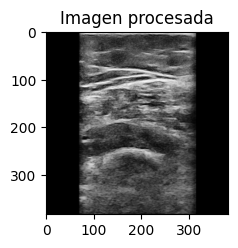

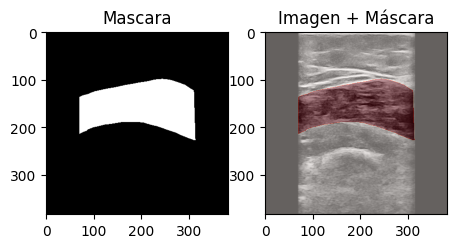

In [10]:
def show_pair(img_path, mask_path):
    img = load_image(img_path)
    mask = load_mask(mask_path)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.title("Imagen procesada")
    plt.imshow(img, cmap='gray')

    plt.figure(figsize=(8,4))
    plt.subplot(1,3,2)
    plt.title("Mascara")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1,3,3)
    plt.title("Imagen + Máscara")
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.4)
    plt.show()
    

# Mostrar una aleatoria
random_pair = random.choice(pairs)
show_pair(*random_pair)

def load_pair(img_path, mask_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask > 0, 1, 0).astype(np.float32)
    img = np.expand_dims(img, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    return img, mask